# CME538 - Introduction to Data Science
## Lecture 10.3 - Decision Trees & Random Forests

### Lecture Structure
1. [Import Iris Dataset](#section1)
2. [Using a Linear Classifier](#section2)
3. [Decision Trees in scikit-learn](#section3)
4. [Visualizing Decision Trees](#section4)
5. [Training Classification Trees](#section5)
6. [Overfitting](#section6)
7. [Restricting Complexity](#section7)
8. [Random Forests](#section8)
9. [Feature Scaling](#section9)
10. [Regression Trees](#section10)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, fixed, IntSlider
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

<a id='section1'></a>
# Import Iris Dataset
This data sets consists of 3 different types of irises’ (`Setosa`, `Versicolour`, and `Virginica`) petal and sepal length, stored in a 150x4 numpy.ndarray.

Let's import the dataset.

In [2]:
dataset = datasets.load_iris()
iris = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
iris['label'] = dataset['target']
iris['species'] = [dataset['target_names'][label] for label in iris['label'].to_numpy()]
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


Now, Let's plot the `'Petal Length'` and `'Petal Width'`.

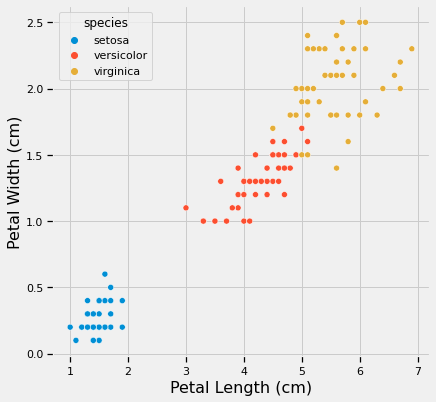

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.subplots_adjust(wspace=0.15)
sns.scatterplot(data=iris, x='petal length (cm)', y='petal width (cm)', hue=iris['species'])
ax.set_xlabel('Petal Length (cm)', fontsize=16)
ax.set_ylabel('Petal Width (cm)', fontsize=16);

<a id='section2'></a>
# Using a Linear Classifier
Let's work with the two petal features from the `Iris` dataset and train a One vs Rest Logistic classifier. You'll recall from Lecture 8.2 that One vs Rest classification involves training one binary classification model for each class as seen below.

<br>
<img src="images/one-vs-all.png" alt="drawing" width="600"/>
<br>

Next, let's fit the model using Scikit-Learn's `LogisticRegression`.

In [4]:
lr_model = LogisticRegression(solver="sag", max_iter=100, 
                              random_state=42, multi_class='ovr').fit(iris[['petal length (cm)', 'petal width (cm)']], 
                                                                      iris['label'])

Next, let's plot the decision boundaries. Some useful functions here.

In [5]:
def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)
    
def plot_prediction_map(model, X, ax):

    # create a mesh to plot in
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    colors = ['#008fd5', '#008fd5', '#fc4f30', '#fc4f30', '#e5ae38', '#e5ae38', '#e5ae38', '#e5ae38']
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, colors=colors, alpha=0.25)

And now for the plot.

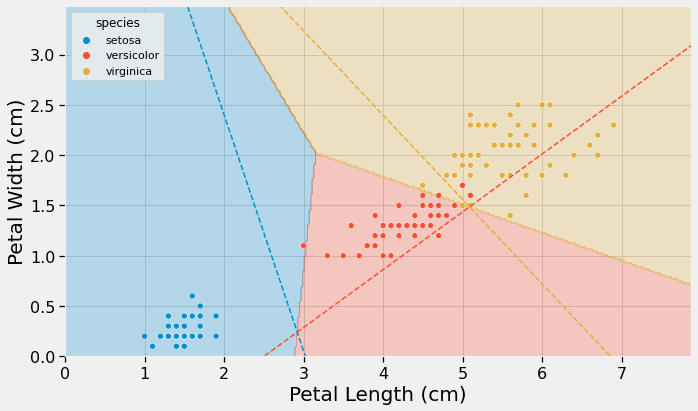

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(lr_model, iris[['petal length (cm)', 'petal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=iris, x='petal length (cm)', y='petal width (cm)', hue=iris['species'])

# plot hyperplanes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
coef = lr_model.coef_
intercept = lr_model.intercept_
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
for i, color in zip(lr_model.classes_, colors):
    plot_hyperplane(i, color)

ax.set_ylim([xmin, xmax])
ax.set_ylim([0, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Petal Length (cm)', fontsize=20)
ax.set_ylabel('Petal Width (cm)', fontsize=20);

<a id='section3'></a>
# Decision Trees in Scikit-Learn
Let's see how to fit a decision tree in scikit-learn. 

Let's import the decision tree classifier. 

In [7]:
from sklearn.tree import DecisionTreeClassifier

Let's initialize the model and then train it. you'll notice that you can pass the model the actual label names instead of integers (`iris['species'] = 'virginica', 'setosa', ...'`) but if you do this, the model will output these string when using the `.predict()` method.

In [8]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(iris[['petal length (cm)', 'petal width (cm)']], 
              iris['species'])

DecisionTreeClassifier()

Now, let's randomly choose choose a few samples and use the model to get predictions.

In [9]:
some_rows = iris.sample(4)
some_rows

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,species
142,5.8,2.7,5.1,1.9,2,virginica
84,5.4,3.0,4.5,1.5,1,versicolor
37,4.9,3.6,1.4,0.1,0,setosa
59,5.2,2.7,3.9,1.4,1,versicolor


How let's predict. You'll notice because we used `iris['species']` as the training label (no `iris['label']`), the model outputs the label name, not an integer.

In [10]:
dtc_model.predict(some_rows[['petal length (cm)', 
                             'petal width (cm)']])

array(['virginica', 'versicolor', 'setosa', 'versicolor'], dtype=object)

Next, let's plot the 2D prediction map like we did for the Logistic Regression model. First, we'll need to retrain the model using `iris['label']` as the training label so our model outputs integers, which is required for the countour plot.

In [11]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(iris[['petal length (cm)', 'petal width (cm)']], iris['label'])

DecisionTreeClassifier()

Next, let's plot the decision boundaries.

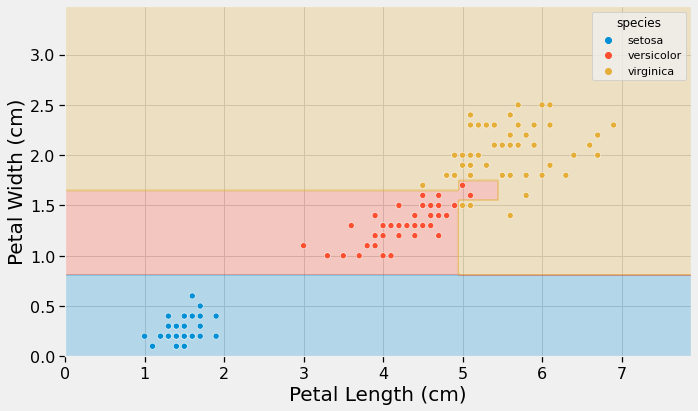

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, iris[['petal length (cm)', 'petal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=iris, x='petal length (cm)', y='petal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([0, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Petal Length (cm)', fontsize=20)
ax.set_ylabel('Petal Width (cm)', fontsize=20);

Now let's compute the training accuracy.

In [13]:
dtc_model.score(iris[['petal length (cm)', 'petal width (cm)']], iris['label'])

0.9933333333333333

Let's find out which records may have the same petal length and width but different classes.

In [14]:
iris[(iris['petal length (cm)'] > 2.45) & 
     (iris['petal width (cm)'] > 1.75) & 
     (iris['petal length (cm)'] < 4.85)]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,species
70,5.9,3.2,4.8,1.8,1,versicolor
126,6.2,2.8,4.8,1.8,2,virginica
138,6.0,3.0,4.8,1.8,2,virginica


<a id='section4'></a>
# Visualizing Decision Trees
First, let's retrain out model.

In [15]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(iris[['petal length (cm)', 'petal width (cm)']], iris['species'])

DecisionTreeClassifier()

#### graphviz
Let's use `graphviz` to visualize our decision tree.

In [16]:
import graphviz
import pydotplus

dot_data = tree.export_graphviz(dtc_model, out_file=None, 
                                feature_names=['petal length (cm)', 'petal width (cm)'],  
                                class_names=iris['species'].unique(),
                                rounded=True, filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png(os.path.join(os.path.abspath(os.getcwd()), 'graphviz1.png'))

True

#### dtressviz
Now, let's use an even cooler tree visualizer called `dtreeviz`. First, let's retrain our model again.

In [17]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(iris[['petal length (cm)', 'petal width (cm)']], iris['label'])

DecisionTreeClassifier()

Next, we'll visualize the tree.

In [18]:
from dtreeviz.trees import dtreeviz

colors = [None,  # 0 classes
          None,  # 1 class
          ['#FEFEBB', '#a1dab4'],  # 2 classes
          ['#008fd5', '#fc4f30', '#e5ae38'],  # 3 classes
         ]

viz = dtreeviz(dtc_model,
               iris[['petal length (cm)', 'petal width (cm)']].to_numpy(),
               iris['label'].to_numpy(),
               target_name='Species',
               feature_names=['petal length (cm)', 'petal width (cm)'],
               class_names=list(iris['species'].unique()),
               colors={'classes': colors})
              
viz.save(os.path.join(os.path.abspath(os.getcwd()), 'dtreeviz1.svg'))

<a id='section5'></a>
# Training Classification Trees
So, let's consider our simple decision tree from the previous section that was only trained on the petal features. Let's retrain the model.

In [19]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(iris[['petal length (cm)', 'petal width (cm)']], iris['label'])

DecisionTreeClassifier()

Next, take a look at the decision tree visualization we saved using `graphviz`. The black cell doesn't mean anything.

<br>
<img src="graphviz1.png" alt="drawing" width="600"/>
<br>

### First Split
For our first decision at the root node, let's work through the calculations.
#### Petal Length
First, let's check out the petal lengths in ascending order.

In [20]:
petal_lengths = iris['petal length (cm)'].sort_values().drop_duplicates()
petal_lengths

22     1.0
13     1.1
14     1.2
36     1.3
45     1.4
34     1.5
30     1.6
18     1.7
24     1.9
98     3.0
93     3.3
60     3.5
64     3.6
81     3.7
80     3.8
69     3.9
62     4.0
88     4.1
61     4.2
97     4.3
75     4.4
106    4.5
54     4.6
63     4.7
70     4.8
72     4.9
146    5.0
141    5.1
147    5.2
111    5.3
139    5.4
137    5.5
136    5.6
144    5.7
108    5.8
102    5.9
100    6.0
130    6.1
107    6.3
131    6.4
105    6.6
117    6.7
118    6.9
Name: petal length (cm), dtype: float64

And let's look at the midpoints.

In [21]:
petal_lengths_rules = (petal_lengths + (petal_lengths.shift(1) - petal_lengths) / 2).dropna()
petal_lengths_rules

13     1.05
14     1.15
36     1.25
45     1.35
34     1.45
30     1.55
18     1.65
24     1.80
98     2.45
93     3.15
60     3.40
64     3.55
81     3.65
80     3.75
69     3.85
62     3.95
88     4.05
61     4.15
97     4.25
75     4.35
106    4.45
54     4.55
63     4.65
70     4.75
72     4.85
146    4.95
141    5.05
147    5.15
111    5.25
139    5.35
137    5.45
136    5.55
144    5.65
108    5.75
102    5.85
100    5.95
130    6.05
107    6.20
131    6.35
105    6.50
117    6.65
118    6.80
Name: petal length (cm), dtype: float64

Let's visualize these different splits.

In [22]:
def gini_impurity(df, rule, feature):
    
    # Gini impurity of left dataset
    df_left = df[df[feature] <= rule]
    gini_left = (1 - (df_left[df_left['species'] == 'setosa'].shape[0] / df_left.shape[0])**2 
                   - (df_left[df_left['species'] == 'versicolor'].shape[0] / df_left.shape[0])**2
                   - (df_left[df_left['species'] == 'virginica'].shape[0] / df_left.shape[0])**2)
    
    # Gini impurity of right dataset
    df_right = df[df[feature] > rule]
    gini_right = (1 - (df_right[df_right['species'] == 'setosa'].shape[0] / df_right.shape[0])**2 
                    - (df_right[df_right['species'] == 'versicolor'].shape[0] / df_right.shape[0])**2
                    - (df_right[df_right['species'] == 'virginica'].shape[0] / df_right.shape[0])**2)
    
    # Total Gini impurity
    gini = (df_left.shape[0] / df.shape[0]) * gini_left + (df_right.shape[0] / df.shape[0]) * gini_right
    
    return gini_left, gini_right, gini

def decision_tree_step(rule_id, df, rules, feature):
    
    colors = {'setosa': '#008fd5', 'versicolor': '#fc4f30', 'virginica': '#e5ae38'}
    
    # Compute gini scores
    ginis_left = [gini_impurity(df, split, feature)[0] for split in rules]
    ginis_right = [gini_impurity(df, split, feature)[1] for split in rules]
    ginis = [gini_impurity(df, split, feature)[2] for split in rules]
    
    # Setup figure
    fig = plt.figure(figsize=(10, 14))
    fig.subplots_adjust(wspace=0.22, hspace=0.4)
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    
    # Histogram
    sns.histplot(data=df, stat="count", multiple="stack", x=feature, ax=ax1,
                 kde=False, hue='species', element="bars", legend=True, binwidth=0.1, palette=colors)
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_xlabel(feature, fontsize=18)
    ax1.set_ylabel('Count', fontsize=18)
    xmin, xmax = ax1.get_xlim()
    ymin, ymax = ax1.get_ylim()
    ax1.plot([rules[rule_id], rules[rule_id]], [ymin, ymax], '-', c='#810f7c', lw=6)
    ax1.text(rules[rule_id], ymax, 'Gini (mean): {:0.3f}'.format(ginis[rule_id]), fontsize = 18)
    
    # Gini impurities
    sns.lineplot(rules, ginis, ax=ax2, color='#810f7c', lw=4)
    sns.scatterplot(rules, ginis, ax=ax2, label='Gini (mean)', color='#810f7c', s=150)
    sns.lineplot(rules, ginis_left, ax=ax2, color='#6d904f', alpha=0.5, lw=2)
    sns.scatterplot(rules, ginis_left, ax=ax2, label='Gini (left-node)', color='#6d904f', alpha=0.5)
    sns.lineplot(rules, ginis_right, ax=ax2, color='#8b8b8b', alpha=0.5, lw=2)
    sns.scatterplot(rules, ginis_right, ax=ax2, label='Gini (right-node)', color='#8b8b8b', alpha=0.5)
    ax2.set_xlim([xmin, xmax])
    ax2.xaxis.set_tick_params(labelsize=14)
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.set_xlabel(feature, fontsize=18)
    ax2.set_ylabel('Gini Impurity', fontsize=18)
    ymin, ymax = ax2.get_ylim()
    ax2.plot([rules[rule_id], rules[rule_id]], [ymin, ymax], '-', c='#810f7c', lw=6)
    ax2.text(rules[rule_id], ymax, 'Gini (mean): {:0.3f}'.format(ginis[rule_id]), fontsize = 18)
    
    # Bar charts (left-node)
    setosa_count = df[(df[feature] <= rules[rule_id]) & (df['species'] == 'setosa')].shape[0]
    versicolor_count = df[(df[feature] <= rules[rule_id]) & (df['species'] == 'versicolor')].shape[0]
    virginica_count = df[(df[feature] <= rules[rule_id]) & (df['species'] == 'virginica')].shape[0]
    ax3.set_title('Left Node(<= {})\nGini: {:0.3f}\nsetosa: {} versicolor: {} virginica: {}'.format(rules[rule_id],
                                                                                                    ginis_left[rule_id], 
                                                                                                    setosa_count, 
                                                                                                    versicolor_count, 
                                                                                                    virginica_count), 
                  loc='left', fontsize=14)
    sns.histplot(data=df[df[feature] <= rules[rule_id]], stat="count", multiple="stack", x=feature, ax=ax3,
                 kde=False, hue='species', element="bars", legend=True, palette=colors)
    ax3.xaxis.set_tick_params(labelsize=14)
    ax3.yaxis.set_tick_params(labelsize=14)
    ax3.set_xlabel(feature, fontsize=18)
    ax3.set_ylabel('Count', fontsize=18)
    
    # Bar charts (left-node)
    setosa_count = df[(df[feature] > rules[rule_id]) & (df['species'] == 'setosa')].shape[0]
    versicolor_count = df[(df[feature] > rules[rule_id]) & (df['species'] == 'versicolor')].shape[0]
    virginica_count = df[(df[feature] > rules[rule_id]) & (df['species'] == 'virginica')].shape[0]
    ax4.set_title('Right Node (> {})\nGini: {:0.3f}\nsetosa: {} versicolor: {} virginica: {}'.format(rules[rule_id], 
                                                                                                      ginis_right[rule_id], 
                                                                                                      setosa_count, 
                                                                                                      versicolor_count, 
                                                                                                      virginica_count), 
                  loc='right', fontsize=14)
    sns.histplot(data=df[df[feature] > rules[rule_id]], stat="count", multiple="stack", x=feature, ax=ax4,
                 kde=False, hue='species', element="bars", legend=True, palette=colors)
    ax4.xaxis.set_tick_params(labelsize=14)
    ax4.yaxis.set_tick_params(labelsize=14)
    ax4.set_xlabel(feature, fontsize=18)
    ax4.set_ylabel('Count', fontsize=18)

In [23]:
df = iris.copy()
feature = 'petal length (cm)'
petal_lengths = df['petal length (cm)'].sort_values().drop_duplicates()
petal_lengths_rules = (petal_lengths + (petal_lengths.shift(1) - petal_lengths) / 2).dropna().tolist()

# Launch widget
interact(decision_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(petal_lengths_rules), step=1),
         df=fixed(df),
         rules=fixed(petal_lengths_rules),
         feature=fixed(feature));

interactive(children=(IntSlider(value=0, description='rule_id', max=42), Output()), _dom_classes=('widget-inte…

#### Petal Width

In [24]:
df = iris.copy()
feature = 'petal width (cm)'
petal_widths = df['petal width (cm)'].sort_values().drop_duplicates()
petal_widths_rules = (petal_widths + (petal_widths.shift(1) - petal_widths) / 2).dropna().tolist()

# Launch widget
interact(decision_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(petal_widths_rules), step=1),
         df=fixed(df),
         rules=fixed(petal_widths_rules),
         feature=fixed(feature));

interactive(children=(IntSlider(value=0, description='rule_id', max=21), Output()), _dom_classes=('widget-inte…

### Second Split
#### Petal Length

In [25]:
df = iris[iris['species'] != 'setosa']
feature = 'petal length (cm)'
petal_lengths = df['petal length (cm)'].sort_values().drop_duplicates()
petal_lengths_rules = (petal_lengths + (petal_lengths.shift(1) - petal_lengths) / 2).dropna().tolist()

# Launch widget
interact(decision_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(petal_lengths_rules), step=1),
         df=fixed(df),
         rules=fixed(petal_lengths_rules),
         feature=fixed(feature));

interactive(children=(IntSlider(value=0, description='rule_id', max=33), Output()), _dom_classes=('widget-inte…

#### Petal Width

In [26]:
df = iris[iris['species'] != 'setosa']
feature = 'petal width (cm)'
petal_widths = df['petal width (cm)'].sort_values().drop_duplicates()
petal_widths_rules = (petal_widths + (petal_widths.shift(1) - petal_widths) / 2).dropna().tolist()

# Launch widget
interact(decision_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(petal_widths_rules), step=1),
         df=fixed(df),
         rules=fixed(petal_widths_rules),
         feature=fixed(feature));

interactive(children=(IntSlider(value=0, description='rule_id', max=15), Output()), _dom_classes=('widget-inte…

<a id='section6'></a>
# Overfitting
Let’s see how bad things are by separating our data into train and test sets. We’ll use 75% of the data for training and 25% of the data for testing. Performance on test set gives us an estimate of how well we generalize.

### Petal Data
Let's split into train and test.

In [27]:
train_iris, test_iris = train_test_split(iris, test_size=0.25, 
                                         random_state=22)

Let's fit a model.

In [28]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(train_iris[['petal length (cm)', 'petal width (cm)']], 
              train_iris['label'])

DecisionTreeClassifier()

Compute training accuracy

In [29]:
dtc_model.score(train_iris[['petal length (cm)', 'petal width (cm)']], 
                train_iris['label'])

1.0

Compute testing accuracy

In [30]:
dtc_model.score(test_iris[['petal length (cm)', 'petal width (cm)']], 
                test_iris['label'])

0.8947368421052632

Now let's see the decision boundaries with the training data.

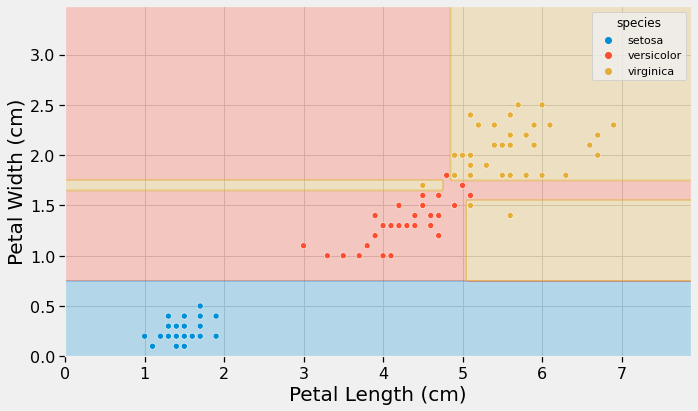

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, train_iris[['petal length (cm)', 'petal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=train_iris, x='petal length (cm)', y='petal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([0, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Petal Length (cm)', fontsize=20)
ax.set_ylabel('Petal Width (cm)', fontsize=20);

Now let's see the decision boundaries with the testing data.

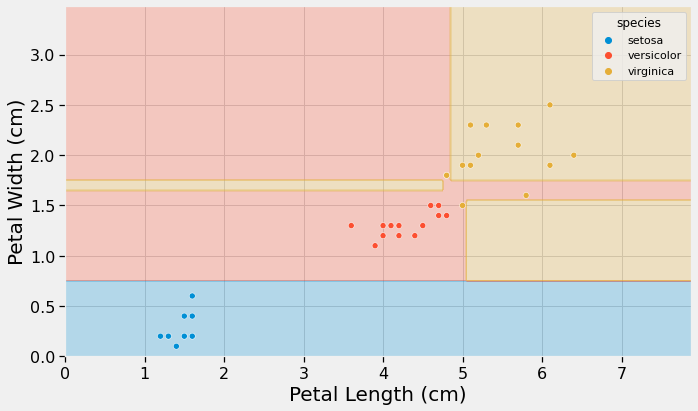

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, train_iris[['petal length (cm)', 'petal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=test_iris, x='petal length (cm)', y='petal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([0, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Petal Length (cm)', fontsize=20)
ax.set_ylabel('Petal Width (cm)', fontsize=20);

### Sepal Data
Let's see what this data looks like.

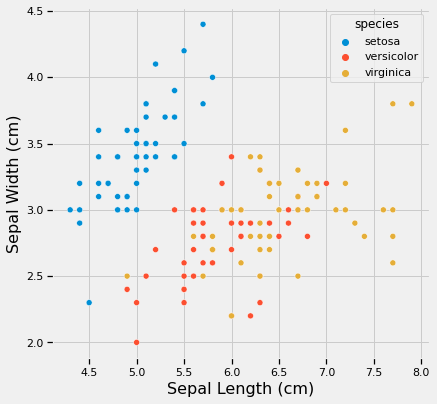

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.subplots_adjust(wspace=0.15)
sns.scatterplot(data=iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])
ax.set_xlabel('Sepal Length (cm)', fontsize=16)
ax.set_ylabel('Sepal Width (cm)', fontsize=16);

Let's split into train and test.

In [34]:
train_iris, test_iris = train_test_split(iris, test_size=0.25, 
                                         random_state=3)

Let's fit a model.

In [35]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
              train_iris['label'])

DecisionTreeClassifier()

Compute training accuracy

In [36]:
dtc_model.score(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
                train_iris['label'])

0.9464285714285714

Compute testing accuracy

In [37]:
dtc_model.score(test_iris[['sepal length (cm)', 'sepal width (cm)']], 
                test_iris['label'])

0.6052631578947368

Now let's see the decision boundaries with the training data.

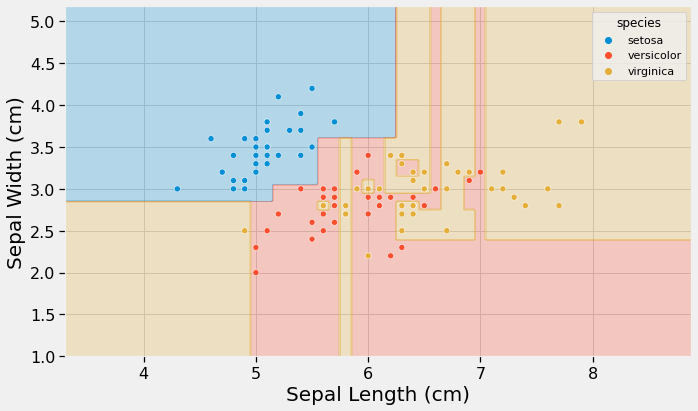

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=train_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

Now let's see the decision boundaries with the testing data.

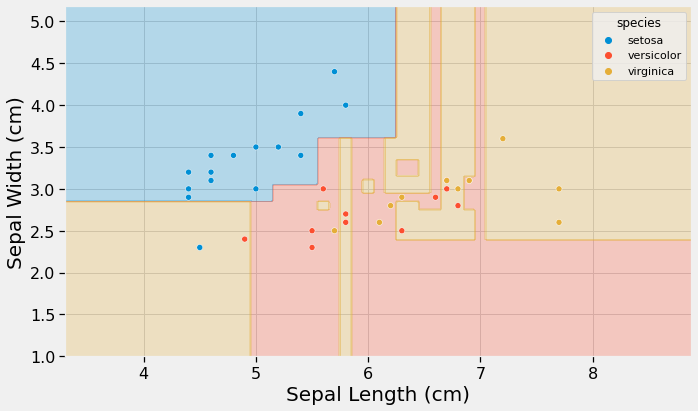

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=test_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

In [40]:
from dtreeviz.trees import dtreeviz

colors = [None,  # 0 classes
          None,  # 1 class
          ['#FEFEBB', '#a1dab4'],  # 2 classes
          ['#008fd5', '#fc4f30', '#e5ae38'],  # 3 classes
         ]

viz = dtreeviz(dtc_model,
               iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(),
               iris['label'].to_numpy(),
               target_name='Species',
               feature_names=['sepal length (cm)', 'sepal width (cm)'],
               class_names=list(iris['species'].unique()),
               colors={'classes': colors})
              
viz.save(os.path.join(os.path.abspath(os.getcwd()), 'dtreeviz2.svg'))

Let's try training a logistic regression model.

In [41]:
lr_model = LogisticRegression(solver="sag", max_iter=100, 
                              random_state=42, multi_class='ovr').fit(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
                                                                      train_iris['label'])

Compute training accuracy

In [42]:
lr_model.score(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
               train_iris['label'])

0.7946428571428571

Compute testing accuracy

In [43]:
lr_model.score(test_iris[['sepal length (cm)', 'sepal width (cm)']], 
               test_iris['label'])

0.7631578947368421

Now let's see the decision boundaries with the training data.

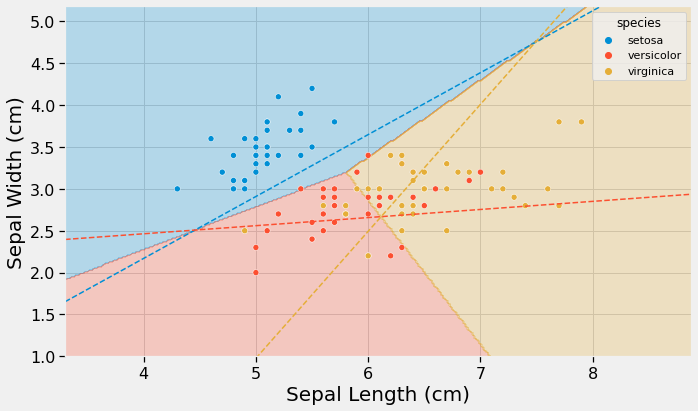

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(lr_model, train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=train_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

# plot hyperplanes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
coef = lr_model.coef_
intercept = lr_model.intercept_
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
for i, color in zip(lr_model.classes_, colors):
    plot_hyperplane(i, color)

ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

Now let's see the decision boundaries with the test data.

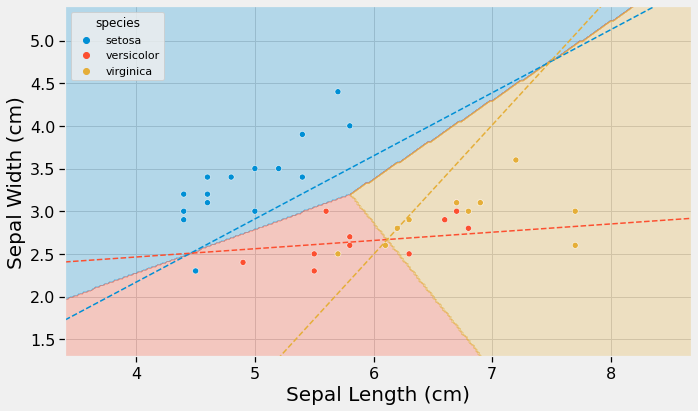

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(lr_model, test_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=test_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

# plot hyperplanes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
coef = lr_model.coef_
intercept = lr_model.intercept_
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
for i, color in zip(lr_model.classes_, colors):
    plot_hyperplane(i, color)

ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

<a id='section7'></a>
# Restricting Complexity
Let's see what hyper-parameters the decision tree has.

In [46]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Let's split into train and test.

In [47]:
train_iris, test_iris = train_test_split(iris, test_size=0.25, 
                                         random_state=3)

Let's fit a model.

In [48]:
dtc_model = DecisionTreeClassifier(max_depth=4, min_samples_split=10)
dtc_model.fit(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
              train_iris['label'])

DecisionTreeClassifier(max_depth=4, min_samples_split=10)

Compute training accuracy

In [49]:
dtc_model.score(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
                train_iris['label'])

0.8392857142857143

Compute testing accuracy

In [50]:
dtc_model.score(test_iris[['sepal length (cm)', 'sepal width (cm)']], 
                test_iris['label'])

0.7368421052631579

Now let's see the decision boundaries with the training data.

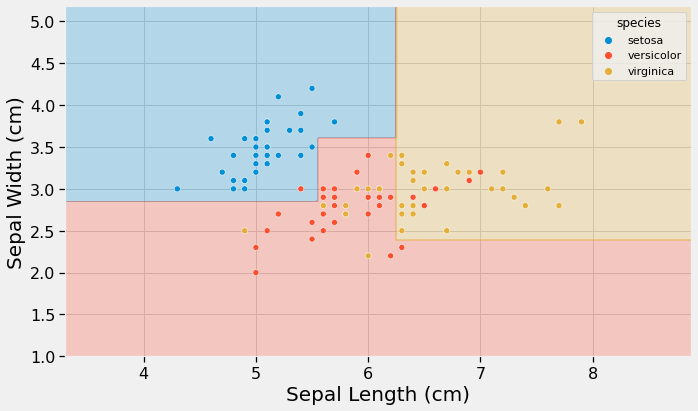

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=train_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

Now let's see the decision boundaries with the testing data.

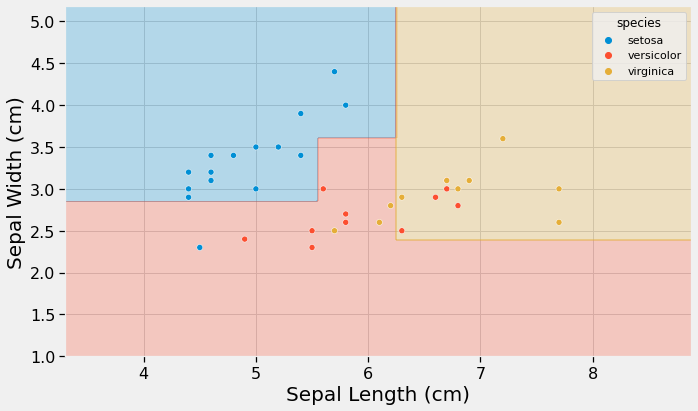

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(dtc_model, train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=test_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

<a id='section8'></a>
# Random Forests
Let's grab out dataset again.

In [53]:
train_iris, test_iris = train_test_split(iris, test_size=0.25, 
                                         random_state=3)

Let's import the Random Forest classifier.

In [54]:
from sklearn.ensemble import RandomForestClassifier

Let's initilize a Random Forest with  3 trees (estimators).

In [55]:
rfc_model = RandomForestClassifier(n_estimators=3, 
                                   max_features=None, 
                                   bootstrap=False, 
                                   max_samples=None)

And let's train the model.

In [56]:
rfc_model.fit(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
              train_iris['label'])

RandomForestClassifier(bootstrap=False, max_features=None, n_estimators=3)

Let's check out the trees. We get a list of 3 trees.

In [57]:
rfc_model.estimators_

[DecisionTreeClassifier(random_state=335433910),
 DecisionTreeClassifier(random_state=1990003760),
 DecisionTreeClassifier(random_state=1584151584)]

Compute training accuracy

In [58]:
rfc_model.score(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
                train_iris['label'])

0.9464285714285714

Compute testing accuracy

In [59]:
rfc_model.score(test_iris[['sepal length (cm)', 'sepal width (cm)']], 
                test_iris['label'])

0.6052631578947368

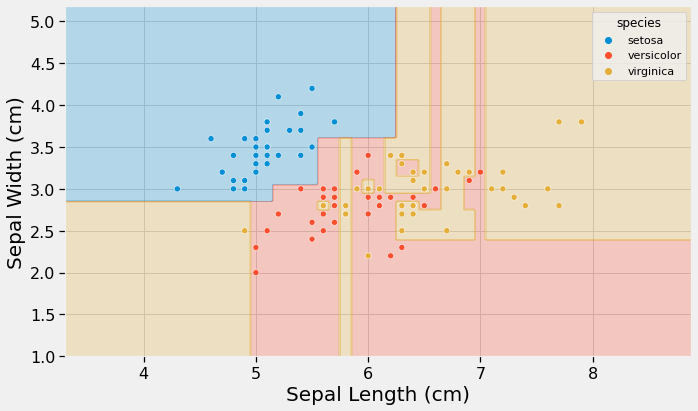

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(rfc_model.estimators_[0], train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=train_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

## Bagging
We address the overfitting by using bagging (boostrap aggrigating).

In [61]:
rfc_model = RandomForestClassifier(n_estimators=3, 
                                   max_features=None, 
                                   bootstrap=True, 
                                   max_samples=0.75)

And let's train the model.

In [62]:
rfc_model.fit(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
              train_iris['label'])

RandomForestClassifier(max_features=None, max_samples=0.75, n_estimators=3)

Let's check out the trees. We get a list of 3 trees.

In [63]:
rfc_model.estimators_

[DecisionTreeClassifier(random_state=22838550),
 DecisionTreeClassifier(random_state=644849079),
 DecisionTreeClassifier(random_state=1189701222)]

Compute training accuracy

In [64]:
rfc_model.score(train_iris[['sepal length (cm)', 'sepal width (cm)']], 
                train_iris['label'])

0.9107142857142857

Compute testing accuracy

In [65]:
rfc_model.score(test_iris[['sepal length (cm)', 'sepal width (cm)']], 
                test_iris['label'])

0.6578947368421053

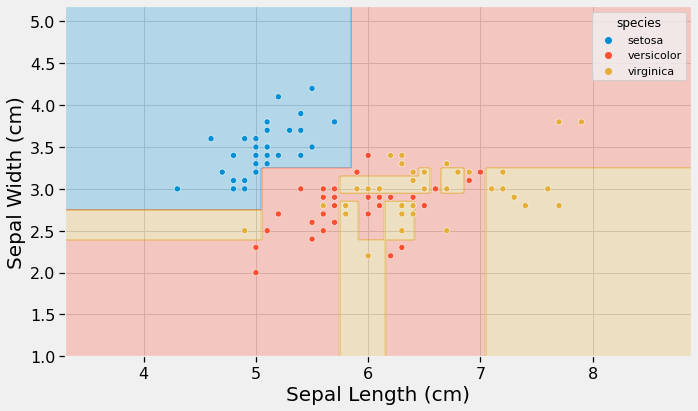

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(rfc_model.estimators_[2], train_iris[['sepal length (cm)', 'sepal width (cm)']].to_numpy(), ax)

# Plot data points
sns.scatterplot(data=train_iris, x='sepal length (cm)', y='sepal width (cm)', hue=iris['species'])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_ylim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Sepal Length (cm)', fontsize=20)
ax.set_ylabel('Sepal Width (cm)', fontsize=20);

## Bagging With Feature Sampling
Let's try this with all 4 of our features.

In [67]:
rfc_model = RandomForestClassifier(n_estimators=3, 
                                   max_features=0.75, 
                                   bootstrap=True, 
                                   max_samples=0.75,
                                   random_state=1)

And let's train the model.

In [68]:
rfc_model.fit(train_iris[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']], 
              train_iris['label'])

RandomForestClassifier(max_features=0.75, max_samples=0.75, n_estimators=3,
                       random_state=1)

Let's check out the trees. We get a list of 3 trees.

In [69]:
rfc_model.estimators_

[DecisionTreeClassifier(max_features=0.75, random_state=1791095845),
 DecisionTreeClassifier(max_features=0.75, random_state=2135392491),
 DecisionTreeClassifier(max_features=0.75, random_state=946286476)]

Compute training accuracy

In [70]:
rfc_model.score(train_iris[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']], 
                train_iris['label'])

0.9732142857142857

Compute testing accuracy

In [71]:
rfc_model.score(test_iris[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']], 
                test_iris['label'])

0.9210526315789473

Let's see the prediction probabilities.

In [72]:
rfc_model.predict_proba(test_iris[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']])[0:20]

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ]])

<a id='section9'></a>
# Feature Scaling
Let's create a dummy dataset where we scale `'petal length (cm)'` by a factor of 100.

In [73]:
train_iris_unscaled = train_iris.copy()
train_iris_unscaled['petal length (cm)'] = train_iris_unscaled['petal length (cm)'] * 100
test_iris_unscaled = test_iris.copy()
test_iris_unscaled['petal length (cm)'] = test_iris_unscaled['petal length (cm)'] * 100

Now, let's plot.

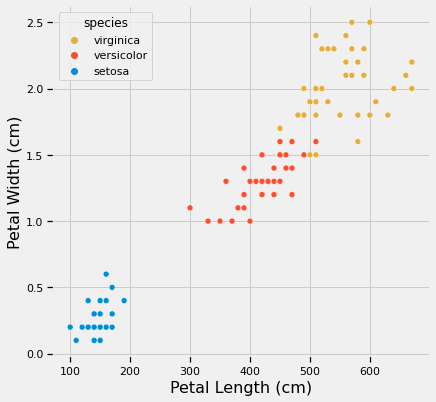

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.subplots_adjust(wspace=0.15)
colors = {'setosa': '#008fd5', 'versicolor': '#fc4f30', 'virginica': '#e5ae38'}
sns.scatterplot(data=train_iris_unscaled, x='petal length (cm)', y='petal width (cm)', hue=train_iris['species'], palette=colors)
ax.set_xlabel('Petal Length (cm)', fontsize=16)
ax.set_ylabel('Petal Width (cm)', fontsize=16);

Train a Logistic Regression model.

In [75]:
lr_model = LogisticRegression(solver="sag", max_iter=100, 
                              random_state=42, multi_class='ovr').fit(train_iris_unscaled[['petal length (cm)', 'petal width (cm)']], 
                                                                      train_iris_unscaled['label'])

Get the train score.

In [76]:
lr_model.score(train_iris_unscaled[['petal length (cm)', 'petal width (cm)']], 
               train_iris_unscaled['label'])

0.3482142857142857

Get the test score.

In [77]:
lr_model.score(test_iris_unscaled[['petal length (cm)', 'petal width (cm)']], 
               test_iris_unscaled['label'])

0.2894736842105263

Plot the decision boundaries.

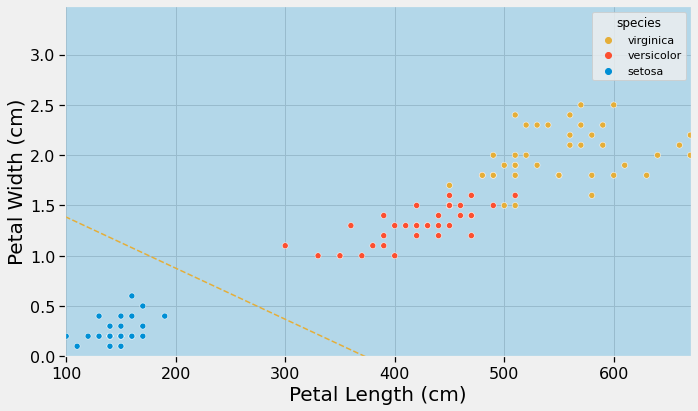

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(lr_model, train_iris_unscaled[['petal length (cm)', 'petal width (cm)']].to_numpy(), ax)

# Plot data points
colors = {'setosa': '#008fd5', 'versicolor': '#fc4f30', 'virginica': '#e5ae38'}
sns.scatterplot(data=train_iris_unscaled, x='petal length (cm)', y='petal width (cm)', hue=train_iris_unscaled['species'], palette=colors)

# plot hyperplanes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
coef = lr_model.coef_
intercept = lr_model.intercept_
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
for i, color in zip(lr_model.classes_, colors):
    plot_hyperplane(i, color)

ax.set_ylim([xmin, xmax])
ax.set_ylim([0, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Petal Length (cm)', fontsize=20)
ax.set_ylabel('Petal Width (cm)', fontsize=20);

Next, let's try the same thing with a Random Forest Model.

In [79]:
rfc_model = RandomForestClassifier(n_estimators=5)
rfc_model.fit(train_iris_unscaled[['petal length (cm)', 'petal width (cm)']], 
              train_iris_unscaled['label'])

RandomForestClassifier(n_estimators=5)

Get the train score.

In [80]:
rfc_model.score(train_iris_unscaled[['petal length (cm)', 'petal width (cm)']], 
                train_iris_unscaled['label'])

0.9821428571428571

Get the test score.

In [81]:
rfc_model.score(test_iris_unscaled[['petal length (cm)', 'petal width (cm)']], 
                test_iris_unscaled['label'])

0.9736842105263158

Plot the decision boundaries.

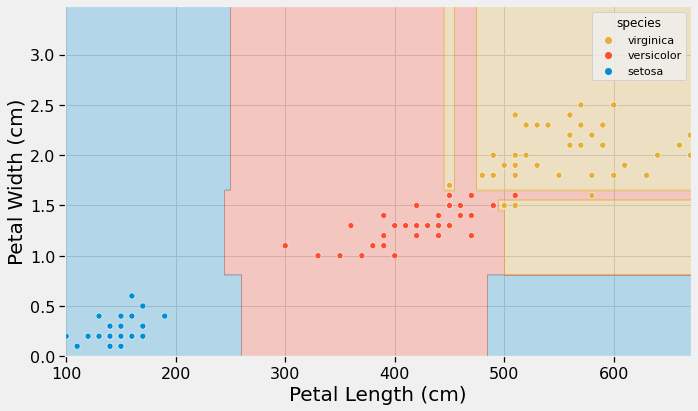

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.15)

# Plot contour
plot_prediction_map(rfc_model, train_iris_unscaled[['petal length (cm)', 'petal width (cm)']].to_numpy(), ax)

# Plot data points
colors = {'setosa': '#008fd5', 'versicolor': '#fc4f30', 'virginica': '#e5ae38'}
sns.scatterplot(data=train_iris_unscaled, x='petal length (cm)', y='petal width (cm)', hue=train_iris_unscaled['species'], palette=colors)

ax.set_ylim([xmin, xmax])
ax.set_ylim([0, ymax])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Petal Length (cm)', fontsize=20)
ax.set_ylabel('Petal Width (cm)', fontsize=20);

<a id='section10'></a>
# Regression Trees
Let's import the decision tree regressor.

In [83]:
from sklearn.tree import DecisionTreeRegressor

Let's train a regression tree that predicts `'petal length'` from `'sepal width'`, `'sepal length'`, and `'petal width'`.

In [84]:
dtc_model = DecisionTreeRegressor(max_depth=2)
dtc_model.fit(iris[['sepal width (cm)', 'sepal length (cm)', 'petal width (cm)']], iris['petal length (cm)'])

DecisionTreeRegressor(max_depth=2)

Next, let's use `dtreeviz` to visualize the decision tree.

In [85]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(dtc_model,
               iris[['sepal width (cm)', 'sepal length (cm)', 'petal width (cm)']].to_numpy(),
               iris['petal length (cm)'].to_numpy(),
               target_name='petal length (cm)',
               feature_names=['sepal width (cm)', 'sepal length (cm)', 'petal width (cm)'],
               colors={'scatter_marker': '#008fd5'})
              
viz.save(os.path.join(os.path.abspath(os.getcwd()), 'dtreeviz3.svg'))

Let's create some functions to help up visualize the regression tree.

In [86]:
def mse_score(df, rule, feature, target):
    
    # mse of left dataset
    df_left = df[df[feature] <= rule]
    mean_left = df_left[target].mean()
    mse_left = np.mean((mean_left - df_left[target])**2)
    
    
    # mse of right dataset
    df_right = df[df[feature] > rule]
    mean_right = df_right[target].mean()
    mse_right = np.mean((mean_right - df_right[target])**2)
    
    # Total mse
    mse = mse_left + mse_right
    
    return mean_left, mse_left, mean_right, mse_right, mse

def regression_tree_step(rule_id, df, rules, feature, target):
    
    # Compute gini scores
    means_left = [mse_score(df, split, feature, target)[0] for split in rules]
    mses_left = [mse_score(df, split, feature, target)[1] for split in rules]
    means_right = [mse_score(df, split, feature, target)[2] for split in rules]
    mses_right = [mse_score(df, split, feature, target)[3] for split in rules]
    mses = [mse_score(df, split, feature, target)[4] for split in rules]

    # Setup figure
    fig = plt.figure(figsize=(10, 14))
    fig.subplots_adjust(wspace=0.22, hspace=0.4)
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
      
    # Scatter plot
    ax1.vlines(df[feature][df[feature] <= rules[rule_id]], ymin=df[target][df[feature] <= rules[rule_id]], ymax=means_left[rule_id],
               linestyle='-', color='#810f7c', alpha=0.3, zorder=0, label='Error (left)')
    ax1.vlines(df[feature][df[feature] > rules[rule_id]], ymin=df[target][df[feature] > rules[rule_id]], ymax=means_right[rule_id],
               linestyle='-', color='#810f7c', alpha=0.3, zorder=0, label='Error (right)')
    sns.scatterplot(data=df, x=feature, y=target, ax=ax1)
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_xlabel(feature, fontsize=18)
    ax1.set_ylabel(target, fontsize=18)
    xmin, xmax = ax1.get_xlim()
    ymin, ymax = ax1.get_ylim()
    ax1.plot([rules[rule_id], rules[rule_id]], [ymin, ymax], '-', c='#810f7c', lw=6)
    ax1.plot([xmin, rules[rule_id]], [means_left[rule_id], means_left[rule_id]], '--', c='#810f7c', lw=2, zorder=0)
    ax1.plot([rules[rule_id], xmax], [means_right[rule_id], means_right[rule_id]], '--', c='#810f7c', lw=2, zorder=0)
    ax1.text(rules[rule_id], ymax, 'MSE: {:0.3f}'.format(mses[rule_id]), fontsize = 18)
    ax1.set_xlim([xmin, xmax])
    
    # mse scores
    sns.lineplot(rules, mses, ax=ax2, color='#810f7c', lw=4)
    sns.scatterplot(rules, mses, ax=ax2, label='MSE (mean)', color='#810f7c', s=150)
    sns.lineplot(rules, mses_left, ax=ax2, color='#6d904f', alpha=0.5, lw=2)
    sns.scatterplot(rules, mses_left, ax=ax2, label='MSE (left-node)', color='#6d904f', alpha=0.5)
    sns.lineplot(rules, mses_right, ax=ax2, color='#8b8b8b', alpha=0.5, lw=2)
    sns.scatterplot(rules, mses_right, ax=ax2, label='MSE (right-node)', color='#8b8b8b', alpha=0.5)
    ax2.set_xlim([xmin, xmax])
    ax2.xaxis.set_tick_params(labelsize=14)
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.set_xlabel(feature, fontsize=18)
    ax2.set_ylabel('Mean Squared Error', fontsize=18)
    ymin, ymax = ax2.get_ylim()
    ax2.plot([rules[rule_id], rules[rule_id]], [ymin, ymax], '-', c='#810f7c', lw=6)
    ax2.text(rules[rule_id], ymax, 'MSE: {:0.3f}'.format(mses[rule_id]), fontsize = 18)
    
    # Bar charts (left-node)
    ax3.set_title('Left Node (<= {:0.3f})\nMSE: {:0.3f}\n{}: {:0.3f}'.format(rules[rule_id], mses_left[rule_id], target, means_left[rule_id]), loc='left', fontsize=14)
    sns.scatterplot(data=df[df[feature] <= rules[rule_id]], x=feature, y=target, ax=ax3)
    xmin, xmax = ax3.get_xlim()
    ax3.plot([xmin, xmax], [means_left[rule_id], means_left[rule_id]], '--', c='#810f7c', lw=2, zorder=0)
    ax3.xaxis.set_tick_params(labelsize=14)
    ax3.yaxis.set_tick_params(labelsize=14)
    ax3.set_xlabel(feature, fontsize=18)
    ax3.set_ylabel(target, fontsize=18)
    
    # Bar charts (left-node)
    ax4.set_title('Right Node (> {:0.3f})\nMSE: {:0.3f}\n{}: {:0.3f}'.format(rules[rule_id], mses_right[rule_id], target, means_right[rule_id]), loc='right', fontsize=14)
    sns.scatterplot(data=df[df[feature] > rules[rule_id]], x=feature, y=target, ax=ax4)
    xmin, xmax = ax4.get_xlim()
    ax4.plot([xmin, xmax], [means_right[rule_id], means_right[rule_id]], '--', c='#810f7c', lw=2, zorder=0)
    ax4.xaxis.set_tick_params(labelsize=14)
    ax4.yaxis.set_tick_params(labelsize=14)
    ax4.set_xlabel(feature, fontsize=18)
    ax4.set_ylabel(target, fontsize=18)

## First Split
### Feature: `'petal width (cm)'`

In [87]:
df = iris.copy()
feature = 'petal width (cm)'
petal_widths = df['petal width (cm)'].sort_values().drop_duplicates()
petal_widths_rules = (petal_widths + (petal_widths.shift(1) - petal_widths) / 2).dropna().tolist()
target = 'petal length (cm)'

# Launch widget
interact(regression_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(petal_widths_rules), step=1),
         df=fixed(df),
         rules=fixed(petal_widths_rules),
         feature=fixed(feature),
         target=fixed(target));

interactive(children=(IntSlider(value=0, description='rule_id', max=21), Output()), _dom_classes=('widget-inte…

### Feature: `'sepal width (cm)'`

In [88]:
df = iris.copy()
feature = 'sepal width (cm)'
sepal_widths = df['sepal width (cm)'].sort_values().drop_duplicates()
sepal_widths_rules = (sepal_widths + (sepal_widths.shift(1) - sepal_widths) / 2).dropna().tolist()
target = 'petal length (cm)'

# Launch widget
interact(regression_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(sepal_widths_rules), step=1),
         df=fixed(df),
         rules=fixed(sepal_widths_rules),
         feature=fixed(feature),
         target=fixed(target));

interactive(children=(IntSlider(value=0, description='rule_id', max=22), Output()), _dom_classes=('widget-inte…

### Feature: `'sepal length (cm)'`

In [89]:
df = iris.copy()
feature = 'sepal length (cm)'
sepal_lengths = df['sepal length (cm)'].sort_values().drop_duplicates()
sepal_lengths_rules = (sepal_lengths + (sepal_lengths.shift(1) - sepal_lengths) / 2).dropna().tolist()
target = 'petal length (cm)'

# Launch widget
interact(regression_tree_step,
         rule_id=IntSlider(value=0, min=0, max=len(sepal_lengths_rules), step=1),
         df=fixed(df),
         rules=fixed(sepal_lengths_rules),
         feature=fixed(feature),
         target=fixed(target));

interactive(children=(IntSlider(value=0, description='rule_id', max=34), Output()), _dom_classes=('widget-inte…